In [1]:
# MNIST with an MLP, from scratch

# - Step 1: build an MLP from scratch to solve MNIST. Question set: https://fleuret.org/dlc/materials/dlc-practical-3.pdf
# - Step 2: debug your network with backprop ninja and a reference implementation using torch's .backward()
# - Step 3: build the same MLP but will full pytorch code (nn.Linear, etc.)

In [2]:
import math
import torch
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from utils import load_data

In [4]:
train_input, train_target, test_input, test_target = load_data(one_hot_labels = True, normalize = True)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


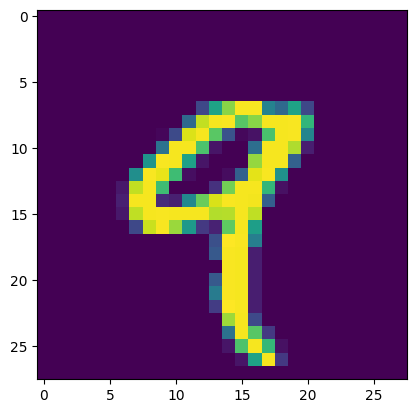

In [5]:
plt.imshow(train_input[4].view((28,28)))

In [6]:
def compute_accuracy (preds, targets):
    """ Computes the accuracy between predictions and targets. Data is expected to be one-hot encoded. """
    _, idx1 = torch.max(preds, dim=1)
    _, idx2 = torch.max(targets, dim=1)
    d = idx1 == idx2
    return d.int().float().mean().item()

In [7]:
# unit test
# this cell should return 0.75
preds = torch.zeros((4,7))
preds[0,1] = 1
preds[1,4] = 1
preds[2,2] = 1
preds[3,6] = 1
targets = torch.zeros((4,7))
targets[0,1] = 1
targets[1,4] = 1
targets[2,2] = 1
targets[3,2] = 1
compute_accuracy(preds, targets)

0.75

In [ ]:
def sigma(x):
    return torch.tanh(x)
              
def dsigma(x):
    return 1 - torch.pow(torch.tanh(x), 2)
    

In [20]:
def loss (v,t):
    return torch.sum(torch.pow(v-t,2)) 

def dloss(v,t):
    return 2*(v-t) 

In [21]:
# sanity check
v = torch.randn((3, 6), dtype=torch.float32)
t = torch.randn((3, 6), dtype=torch.float32)
l = loss(v,t)
dloss(v,t)

tensor([[ 3.5529,  1.1427, -0.1610, -2.0885, -3.8716, -4.2020],
        [ 1.1891,  2.0751,  4.8847,  1.2422, -1.4316, -4.5210],
        [ 5.5198, -1.9320, -1.5009, -2.7508,  0.8101,  1.0077]])

In [22]:
# multiply targets by 0.9 to be in the range of tanh
train_target *= 0.9
test_target *= 0.9

### Step 1: Backprop ninja

In [23]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
# DO NOT MODIFY IT
#
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [24]:
torch.manual_seed(1337)
w1 = torch.randn((784, 50))
b1 = torch.randn((50,))
w2 = torch.randn((50, 10))
b2 = torch.randn((10,))
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad = True

In [25]:
x1 = train_input[:5]
y1 = train_target[:5]
z1 = x1 @ w1 + b1
h1 = sigma(z1)
z2 = h1 @ w2 + b2
h2 = z2
l = loss(h2, y1)
h2.shape, l

(torch.Size([5, 10]), tensor(1427.7395, grad_fn=<SumBackward0>))

In [26]:
# Force pytorch to retain grade for intermediate nodes and reset grad for parameters
# DO NOT MODIFY THIS CODE
#
others = [h2,z2,h1,z1]
for p in parameters:
    p.grad = None
for t in others:
    t.retain_grad()
l.backward()
print(f'loss={l}')

loss=1427.739501953125


In [16]:
# here we compare our gradient to the reference gradient computed by pytorch
dl = 1.0
dh2 = dloss(h2, y1) * dl
cmp('h2',dh2,h2)
dz2 = dh2
cmp('z2',dz2, z2)
dw2 = h1.t() @ dz2
cmp('w2',dw2, w2)
db2 = dz2.sum(axis=0, keepdim=True)
cmp('b2',db2, b2)
dh1 = dz2 @ w2.t()
cmp('h1',dh1, h1)
dz1 = dh1 * dsigma(z1)
cmp('z1', dz1, z1)
dw1 = x1.t() @ dz1
cmp('w1', dw1, w1)
db1 = dz1.sum(axis=0, keepdim=True)
cmp('b1', db1, b1)


h2              | exact: True  | approximate: True  | maxdiff: 0.0
z2              | exact: True  | approximate: True  | maxdiff: 0.0
w2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
h1              | exact: True  | approximate: True  | maxdiff: 0.0
z1              | exact: True  | approximate: True  | maxdiff: 0.0
w1              | exact: True  | approximate: True  | maxdiff: 0.0
b1              | exact: True  | approximate: True  | maxdiff: 0.0


In [17]:
lr = 0.1
with torch.no_grad():
    w1 += -lr * dw1
    b1 += -lr * db1.squeeze()
    w2 += -lr * dw2
    b2 += -lr * db2.squeeze()

In [18]:
l = loss(h2, y1)
l.item()

1426.097900390625

##### Now that we've checked our gradients are correct, we can implement the network

In [32]:
def forward(w1, b1, w2, b2, x):
    z1 = x @ w1 + b1
    h1 = sigma(z1)
    z2 = h1 @ w2 + b2
    h2 = z2
    return z1, h1, z2, h2


In [33]:
def backward(w1, b1, w2, b2, x1, y1, h2, z2, h1, z1):
    dl = 1.0
    dh2 = dloss(h2, y1) * dl
    dz2 = dh2
    dw2 = h1.t() @ dz2
    db2 = dz2.sum(axis=0, keepdim=True)
    dh1 = dz2 @ w2.t()
    dz1 = dh1 * dsigma(z1)
    dw1 = x1.t() @ dz1
    db1 = dz1.sum(axis=0, keepdim=True)
    return dw1, db1, dw2, db2

In [34]:
def update(w1, b1, w2, b2, dw1, db1, dw2, db2, lr):
    with torch.no_grad():
        w1 += -lr * dw1
        b1 += -lr * db1.squeeze()
        w2 += -lr * dw2
        b2 += -lr * db2.squeeze()
    return w1, b1, w2, b2

In [35]:
def init():
    """ init a network """
    w1 = torch.randn((784, 50))
    b1 = torch.randn((50,)) 
    w2 = torch.randn((50, 10))
    b2 = torch.randn((10,))
    return w1, b1, w2, b2

In [36]:
w1, b1, w2, b2 = init()
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad_(True)

Ici pour éviter l'explosion de la loss, on joue sur le learning rate. S'il est trop grand au début du training, les losses explosent. On peut aussi tenter de prendre la moyenne au lieu de la somme pour la loss, ce que l'on ne fait pas ici. 

In [37]:
# main training loop
torch.set_printoptions(linewidth=200)
def train(w1, b1, w2, b2):
    lossi = []
    for step in range(10000):
        xb = train_input
        yb = train_target
        num_samples = xb.shape[0]
        # forward
        z1, h1, z2, h2 = forward(w1, b1, w2, b2, xb)
        lsi = loss(h2, yb)
        # backward
        dw1, db1, dw2, db2 = backward(w1, b1, w2, b2, xb, yb, h2, z2, h1, z1)
        # update
        lr = 0.01 / num_samples if step < 5000 else 0.01 / num_samples
        w1, b1, w2, b2 = update(w1, b1, w2, b2, dw1, db1, dw2, db2, lr)
        if step % 100 == 0: print(f'step = {step}, loss = {lsi}')
        lossi.append(lsi.item())
        #print(lsi.item())
    # compute accuracy
    _, _, _, preds = forward(w1, b1, w2, b2, train_input)
    train_accuracy = compute_accuracy(preds, train_target)
    _, _, _, preds = forward(w1, b1, w2, b2, test_input)
    test_accuracy = compute_accuracy(preds, test_target)
    print(f'{train_accuracy=}')
    print(f'{test_accuracy=}')
    return lossi

In [38]:
lossi = train(w1, b1, w2, b2)

step = 0, loss = 408477.25
step = 100, loss = 28828.1171875
step = 200, loss = 10713.1572265625
step = 300, loss = 5308.1796875
step = 400, loss = 3081.2294921875
step = 500, loss = 1995.146484375
step = 600, loss = 1405.490234375
step = 700, loss = 1065.2857666015625
step = 800, loss = 855.6450805664062
step = 900, loss = 722.3392333984375
step = 1000, loss = 633.9442749023438
step = 1100, loss = 573.2753295898438
step = 1200, loss = 530.39990234375
step = 1300, loss = 499.17767333984375
step = 1400, loss = 475.38043212890625
step = 1500, loss = 452.91680908203125
step = 1600, loss = 438.9681701660156
step = 1700, loss = 428.1716003417969
step = 1800, loss = 419.29779052734375
step = 1900, loss = 412.4455871582031
step = 2000, loss = 406.98651123046875
step = 2100, loss = 402.4430236816406
step = 2200, loss = 398.5719909667969
step = 2300, loss = 395.2218017578125
step = 2400, loss = 392.28643798828125
step = 2500, loss = 389.687744140625
step = 2600, loss = 387.36614990234375
step = 

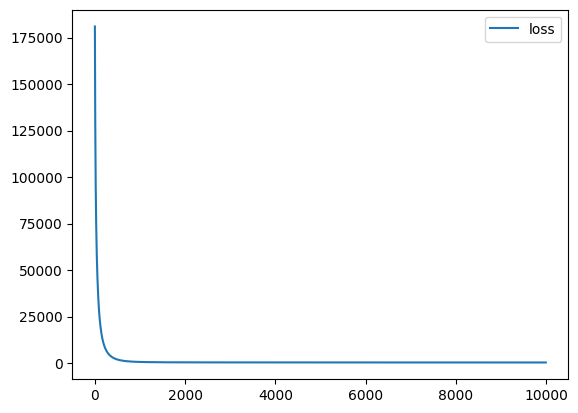

In [39]:
plt.plot(lossi[10:], label='loss')
plt.legend()
plt.show()

### Step 2: Reference implementation using pytorch's .backward()
Nothing to do in Step 2, this code is provided for you as a reference

In [45]:
w1, b1, w2, b2 = init()
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad_(True)

On a pris le même learning rate que précédemment pour éviter l'explosion des losses. 

In [46]:
# reference code
torch.set_printoptions(linewidth=200)
import torch.nn as F

def train(w1, b1, w2, b2):
    lossi = []
    for step in range(10000):
        xb = train_input
        yb = train_target
        num_samples = xb.shape[0]
        # forward
        z1, h1, z2, h2 = forward(w1, b1, w2, b2, xb)
        xloss = F.MSELoss()
        lsi = xloss(h2, yb) * yb.nelement()
        # backward
        for p in parameters:
            p.grad = None
        lsi.backward()
        # update
        lr = 0.01 / num_samples
        for p in parameters:
            p.data += -lr * p.grad
        if step % 100 == 0: print(f'step = {step}, loss = {lsi}')
        lossi.append(lsi.item())
    # compute accuracy
    _, _, _, preds = forward(w1, b1, w2, b2, train_input)
    train_accuracy = compute_accuracy(preds, train_target)
    _, _, _, preds = forward(w1, b1, w2, b2, test_input)
    test_accuracy = compute_accuracy(preds, test_target)
    print(f'{train_accuracy=}')
    print(f'{test_accuracy=}')
    return lossi

In [47]:
lossi = train(w1, b1, w2, b2)

step = 0, loss = 489977.375
step = 100, loss = 29850.802734375
step = 200, loss = 10369.3330078125
step = 300, loss = 4731.6904296875
step = 400, loss = 2535.48095703125
step = 500, loss = 1543.9052734375
step = 600, loss = 1063.3631591796875
step = 700, loss = 810.9407958984375
step = 800, loss = 669.3974609375
step = 900, loss = 585.3501586914062
step = 1000, loss = 532.712646484375
step = 1100, loss = 498.0165100097656
step = 1200, loss = 473.98046875
step = 1300, loss = 456.5047607421875
step = 1400, loss = 443.1932067871094
step = 1500, loss = 432.6089172363281
step = 1600, loss = 423.8834533691406
step = 1700, loss = 416.3723449707031
step = 1800, loss = 409.4836730957031
step = 1900, loss = 403.72210693359375
step = 2000, loss = 398.6879577636719
step = 2100, loss = 394.253662109375
step = 2200, loss = 390.3627014160156
step = 2300, loss = 386.8446350097656
step = 2400, loss = 383.6231689453125
step = 2500, loss = 380.64825439453125
step = 2600, loss = 377.8819885253906
step = 2

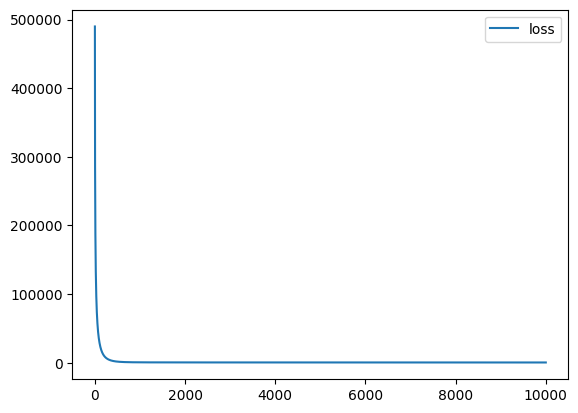

In [48]:
plt.plot(lossi, label='loss')
plt.legend()
plt.show()

### Step 3: Build the same MLP layer but with fully pytorch code (nn.Linear(), etc.)

In [55]:
# network dimensions
n_in = 784
n_hidden = 200
n_out = 10

In [56]:
X_tr, Y_tr = train_input, train_target
X_test, Y_test = test_input, test_target

In [57]:
class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList((
            nn.Linear(n_in, n_hidden),  
            nn.Tanh(),                 
            nn.Linear(n_hidden, n_out)  
        ))

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) 
        return x
    
    def __parameters__(self):
        return [p for layer in self.layers for p in layer.parameters]

model = MLP()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [58]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if n % 1000 == 0: 
        with torch.no_grad():
            # train accuracy
            acc_train = compute_accuracy(y_pred, Y_tr)
            # test accuracy
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')


step =      0	loss=0.14508	accuracy (train, test): 0.05600	0.10300
step =   1000	loss=0.00004	accuracy (train, test): 1.00000	0.87600
step =   2000	loss=0.00000	accuracy (train, test): 1.00000	0.88100
step =   3000	loss=0.00004	accuracy (train, test): 1.00000	0.88200
step =   4000	loss=0.00004	accuracy (train, test): 1.00000	0.88200
step =   5000	loss=0.00000	accuracy (train, test): 1.00000	0.88300
step =   6000	loss=0.00001	accuracy (train, test): 1.00000	0.88200
step =   7000	loss=0.00009	accuracy (train, test): 1.00000	0.88000
step =   8000	loss=0.00004	accuracy (train, test): 1.00000	0.87800
step =   9000	loss=0.00003	accuracy (train, test): 1.00000	0.87400


##### Exercise: try to improve accuracy!

Pour cette exercice, on réalise unE série de modifications par rapport au précédent MLP en espérant améliorer l'accuracy du modèle sur le dataset de test. L'accuracy du train étant déjà à 1 et celle du test déjà très élevée, nous allons voir si on peut faire mieux. 

Tout d'abord, on modifie les fonctions d'activation en prenant des fonctions ReLU. On ajoute également une couche cachée au réseau. On modifie également la fonction de perte, en sélectionnant la cross entropy loss, censée être mieux adapter à la classification.

Enfin, on utilise la méthode de Pytorch "lr_scheduler" qui adapte le learning rate au cours de l'entraînement et est censé améliorer la vitesse de convergence et donc de l'entraînement. 

In [64]:
import torch.optim.lr_scheduler as lr_scheduler ## import the scheduler qui permet de mieux choisir le learning rate

class MLP_upgrade(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList((
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),  
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out)  
        ))

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) 
        return x
    
    def __parameters__(self):
        return [p for layer in self.layers for p in layer.parameters]

model = MLP_upgrade()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)
loss_fn = nn.CrossEntropyLoss()


In [65]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step() # learning rate update à chaque epoch
    
    if n % 1000 == 0: 
        with torch.no_grad():
            # train accuracy
            acc_train = compute_accuracy(y_pred, Y_tr)
            # test accuracy
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')


step =      0	loss=1.86197	accuracy (train, test): 0.11500	0.39900
step =   1000	loss=0.00004	accuracy (train, test): 1.00000	0.85100
step =   2000	loss=0.00003	accuracy (train, test): 1.00000	0.85200
step =   3000	loss=0.00003	accuracy (train, test): 1.00000	0.85300
step =   4000	loss=0.00002	accuracy (train, test): 1.00000	0.85600
step =   5000	loss=0.00002	accuracy (train, test): 1.00000	0.85700
step =   6000	loss=0.00002	accuracy (train, test): 1.00000	0.86500
step =   7000	loss=0.00002	accuracy (train, test): 1.00000	0.86100
step =   8000	loss=0.00002	accuracy (train, test): 1.00000	0.86500
step =   9000	loss=0.00002	accuracy (train, test): 1.00000	0.86600


On remarque, que l'accuracy de notre précédent réseau est légèrement moins bonne que précédemment. On tente ainsi d'ajouter du dropout dans le réseau pour voir si cela permet effectivement de mieux généraliser, et atteindre une meilleure accuracy out of sample. 

In [66]:
class MLP_upgrade_drop(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList((
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),  # 20% de dropout, choisi arbitrairement 
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out)
        ))

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) 
        return x
    
    def __parameters__(self):
        return [p for layer in self.layers for p in layer.parameters]

model = MLP_upgrade_drop()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)
loss_fn = nn.CrossEntropyLoss()


In [67]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step() # learning rate update à chaque epoch
    
    if n % 1000 == 0: 
        with torch.no_grad():
            # train accuracy
            acc_train = compute_accuracy(y_pred, Y_tr)
            # test accuracy
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')


step =      0	loss=1.87914	accuracy (train, test): 0.07300	0.29800
step =   1000	loss=0.00006	accuracy (train, test): 1.00000	0.85700
step =   2000	loss=0.00006	accuracy (train, test): 1.00000	0.86300
step =   3000	loss=0.00001	accuracy (train, test): 1.00000	0.86100
step =   4000	loss=0.00002	accuracy (train, test): 1.00000	0.86000
step =   5000	loss=0.00003	accuracy (train, test): 1.00000	0.86900
step =   6000	loss=0.00002	accuracy (train, test): 1.00000	0.86500
step =   7000	loss=0.00003	accuracy (train, test): 1.00000	0.87700
step =   8000	loss=0.00004	accuracy (train, test): 1.00000	0.88400
step =   9000	loss=0.00002	accuracy (train, test): 1.00000	0.88000


On atteint des performance très légèrement meilleures que le premier réseau.